## Agentic RAG – Proof of Concept (LangGraph + FAISS + Hugging Face + Ollama)

# Goal: arXiv paper -> chunks -> embeddings -> FAISS -> retrieve()

## Environment setup
This notebook is a minimal, local Agentic RAG proof-of-concept. The following cell installs only the packages required to:
- load and chunk documents
- embed chunks and build a FAISS vector index
- run a local LLM via `init_chat_model` (e.g., Ollama)
- orchestrate agentic control flow with LangGraph

In [1]:
#Only run this cell if you are not using the environment with the dependencies installed from the pyproject.toml file

%pip install -U \
  transformers \
  langgraph langchain-community langchain-text-splitters langchain-ollama langchain-huggingface\
  sentence-transformers \
  torch langchain-docling \
  faiss-cpu

Note: you may need to restart the kernel to use updated packages.


## Imports and reproducibility
We import only what is needed for a clear, reproducible baseline. A fixed random seed makes the pipeline deterministic for demonstration.

Key points:
- keep imports minimal (clarity over breadth)
- set a global seed for `random` and `numpy`


In [2]:
import random

import numpy as np

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Document loading and chunking
We use Docling to load a single arXiv PDF and split it into chunks suitable for embedding. Two export modes are supported:
- `DOC_CHUNKS` (default): uses the loader's hybrid chunker
- `MARKDOWN`: uses header-based splitting (shown for completeness)

This step turns raw text into semantically meaningful pieces for retrieval.

In [3]:
from docling.chunking import HybridChunker
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType

FILE_PATH = ["https://arxiv.org/pdf/2506.19676"]
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L12-v2"
GEN_MODEL_ID = "ollama:qwen3:4b"
EXPORT_TYPE = ExportType.DOC_CHUNKS

loader = DoclingLoader(
    file_path=FILE_PATH,
    export_type=EXPORT_TYPE,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)

docs = loader.load()

if EXPORT_TYPE == ExportType.DOC_CHUNKS:
    splits = docs
elif EXPORT_TYPE == ExportType.MARKDOWN:
    from langchain_text_splitters import MarkdownHeaderTextSplitter

    splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[
            ("#", "Header_1"),
            ("##", "Header_2"),
            ("###", "Header_3"),
        ],
    )
    splits = [split for doc in docs for split in splitter.split_text(doc.page_content)]
else:
    raise ValueError(f"Unexpected export type: {EXPORT_TYPE}")

for d in splits[:3]:
    print(f"- {d.page_content=}")
print("...")

/Users/zelenyianszkimate/Documents/Agentic-RAG-PoC/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zelenyianszkimate/Documents/Agentic-RAG-PoC/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Token indices sequence length is longer than the specified maximum sequence length for this model (5188 > 512). Running this sequence through the model will result in indexing errors


- d.page_content='A Survey of LLM-Driven AI Agent Communication: Protocols, Security Risks, and Defense Countermeasures\nDezhang Kong, Shi Lin, Zhenhua Xu, Zhebo Wang, Minghao Li, Yufeng Li, Yilun Zhang, Hujin Peng, Zeyang Sha, Yuyuan Li, Changting Lin, Xun Wang, Xuan Liu, Ningyu Zhang, Chaochao Chen, Muhammad Khurram Khan, Meng Han'
- d.page_content='A Survey of LLM-Driven AI Agent Communication: Protocols, Security Risks, and Defense Countermeasures\nAbstract -In recent years, Large-Language-Model-driven AI agents have exhibited unprecedented intelligence and adaptability, and are rapidly changing human production and life. Nowadays, agents are undergoing a new round of evolution. They no longer act as an isolated island like LLMs. Instead, they start to communicate with diverse external entities, such as other agents and tools, to perform more complex tasks collectively. Under this trend, agent communication is regarded as a foundational pillar of the future AI ecosystem, and many o

## Vector store and retriever
We embed the chunks with `sentence-transformers` and build a FAISS index. Then we expose a `retriever` and wrap it as a LangChain "tool" so the agent can decide to call it.

Why FAISS?
- fast, local approximate nearest-neighbor search
- works well for PoC and small datasets


In [4]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

print("Building FAISS index from documents...")
vectorstore = FAISS.from_documents(splits, embeddings)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

retriever_tool = create_retriever_tool(
    retriever,
    "arxiv_paper_retriever",
    "Retrieves and answers the question about the arxiv paper",
)

print(f"FAISS index size: {vectorstore.index.ntotal}")
print(f"Number of document chunks: {len(splits)}")

# If the index is empty, add documents:
if vectorstore.index.ntotal == 0:
    print("Populating the FAISS index...")
    vectorstore.add_documents(splits)
    print(f"FAISS index size after update: {vectorstore.index.ntotal}")

Building FAISS index from documents...
FAISS index size: 695
Number of document chunks: 695


## Agentic decision: retrieve or respond
We initialize a local chat model and define a function that lets the LLM decide autonomously whether to call the retriever tool or answer directly.

This demonstrates agentic behavior: tool-use planning vs direct generation.


In [5]:
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState

response_model = init_chat_model(GEN_MODEL_ID, temperature=0)


def generate_query_or_respond(state: MessagesState):
    """
    Call the model to generate a response based on the current state.
    The LLM will decide to use the retriever tool, or respond directly.
    """
    response = response_model.bind_tools([retriever_tool]).invoke(state["messages"])
    return {"messages": [response]}

In [6]:
# Check if the retriever tool is working


input = {
    "messages": [
        {
            "role": "user",
            "content": "What is the main idea of the arxiv paper?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user is asking about the main idea of an arXiv paper. But wait, they didn't specify which paper. Hmm, the function provided is arxiv_paper_retriever, which requires a query. Since the user didn't mention a specific paper title or ID, I can't retrieve the main idea without knowing which paper they're referring to.

I should check the tools again. The function needs a "query" parameter. The user's question is too vague here. Maybe they expect me to ask for clarification, but according to the instructions, I need to call the function if possible. Wait, the problem says "You may call one or more functions to assist with the user query." But in this case, without a specific query, the function can't be called properly.

Wait, the user's message is "What is the main idea of the arxiv paper?" which is a bit unclear. They might have meant a specific paper but forgot to mention it. Since the func

## Relevance grading
We add a lightweight, LLM-based grader that checks if retrieved context is relevant to the user question.

Outputs a binary decision that controls the next step:
- relevant -> generate answer
- not relevant -> rewrite question

In [7]:
from typing import Literal

from pydantic import BaseModel, Field

# GRADE_PROMPT – binary relevance grader (returns yes/no)

GRADE_PROMPT = (
    "You are an expert RAG evaluator. Decide if the retrieved CONTEXT is "
    "useful to answer the USER QUESTION.\n\n"
    "Evaluation rubric (relevant = 'yes'):\n"
    "- The context contains facts, definitions, steps, or terminology that directly support answering the question.\n"
    "- The context matches the semantic intent (not just surface keywords).\n"
    "- Minor wording differences are acceptable if the meaning aligns.\n"
    "Irrelevant = 'no' when the context is off-topic, purely generic, or lacks the key facts needed.\n\n"
    "USER QUESTION:\n{question}\n\n"
    "CONTEXT:\n{context}\n\n"
    "Answer strictly with 'yes' or 'no'."
)


class GradeDocuments(BaseModel):
    "Grade documents using a binary score for relevance check."

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("ollama:qwen3:4b", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question.
    Input:
    - question: str
    - context: str
    Output:
    - binary_score: str

    """
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.with_structured_output(GradeDocuments).invoke(
        [{"role": "user", "content": prompt}]
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [ ]:
# Check if the grader function is working for rewriting the question


from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What are the main limitations of the current agent protocols?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "something else", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [9]:
# Check if the grade documents function is working for generating an answer

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What is the main idea of the paper?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "arxiv_paper_retriever",
                        "args": {"query": "paper main idea"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "The main idea of the paper is that agent communication is a new and promising research field.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## Question rewriting
If context is not relevant, the agent rewrites the user question to better capture the intended meaning and improve retrieval on the next iteration.

In [ ]:
from langchain_core.messages import HumanMessage

# REWRITE_PROMPT – intent-preserving question rewrite to improve

REWRITE_PROMPT = (
    "Rewrite the user's question to maximize retrieval quality while preserving intent.\n"
    "Guidelines:\n"
    "- Keep it specific and unambiguous; include essential entities, time ranges, and constraints.\n"
    "- Remove vague words; prefer domain terms from the original question when helpful.\n"
    "- Keep it a single, self-contained question; do not add new information.\n\n"
    "Original question:\n-------\n{question}\n-------\n"
    "Improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [11]:
# Check if the rewrite question function is working


input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What is the main idea of the paper?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "arxiv_paper_retriever",
                        "args": {"query": "paper main idea"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1].content)

<think>
We are given the original question: "What is the main idea of the paper?"
 The goal is to rewrite it to maximize retrieval quality while preserving intent.

 Guidelines:
 - Keep it specific and unambiguous; include essential entities, time ranges, and constraints.
 - Remove vague words; prefer domain terms from the original question when helpful.
 - Keep it a single, self-contained question; do not add new information.

 Analysis of the original question:
   - The question is about the "main idea" of a "paper".
   - However, the original question does not specify which paper. This is vague because there are many papers.

 Problem: Without knowing which paper, the question is too broad and cannot be retrieved effectively.

 How to improve?
   - We must include the essential entity: the paper. But the original question doesn't specify which paper.
   - Since the user didn't specify a paper, we have to assume that in the context of the conversation or the system, there might be a 

## Answer generation
Given a user question and relevant context, the model produces a concise answer.

Principles:
- be faithful to provided context
- be brief and clear; admit when unknown

In [12]:
from langchain_core.messages import SystemMessage

# GENERATE_PROMPT – grounded answer generation from provided context

GENERATE_PROMPT = (
    "You are a concise, trustworthy assistant for Retrieval-Augmented QA.\n"
    "Instructions:\n"
    "- Use only the information in CONTEXT. Do not invent facts.\n"
    '- If the answer is not found, say: "I don\'t know based on the provided context."\n'
    "- Prefer 2–4 clear sentences. Use bullet points only if enumerating items.\n"
    "- Be faithful to the source; avoid speculation.\n\n"
    "QUESTION:\n{question}\n\n"
    "CONTEXT:\n{context}\n\n"
    "Final answer:"
)


def generate_answer(state: MessagesState):
    """Generate an answer for a given question with the provided context.
    Input:
    - question: str
    - context: str
    - prompt: str
    Output:
    - answer: str
    """
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )

    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system") or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = response_model.invoke(prompt)
    return {"messages": [response]}

In [13]:
# Check if the answer generation function is working


input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What is the main idea of the paper?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "arxiv_paper_retriever",
                        "args": {"query": "paper main idea"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "More precisely, we first present a clear definition of agent communication and categorize the entire lifecycle of agent communication into three stages: user-agent interaction, agent-agent communication, and agent-environment communication. Next, for each communication phase, we dissect related protocols and analyze the security risks according to the communication characteristics. Then, we summarize and outlook on the possible defense countermeasures for each risk. In addition, we conduct experiments using MCP and A2A to help readers better understand the novel vulnerabilities brought by agent communication. Finally, we discuss open issues and future directions in this promising research field.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

<think>
Hmm, the user is asking about the main idea of a paper, and they've provided some retrieved context. Let me look at that context carefully.

The context describes a paper that defines agent communication and categorizes its lifecycle into three stages: user-agent interaction, agent-agent communication, and agent-environment communication. It then analyzes security risks for each phase and discusses defense countermeasures. There's also mention of experiments using MCP and A2A protocols to identify vulnerabilities.

I need to distill this into the main idea in three sentences max. The core seems to be about how the paper systematically examines agent communication security across different phases, identifies risks, and proposes defenses. 

The user probably wants a concise academic summary - maybe they're a researcher or student working on agent systems security. I should avoid jargon where possibl

## Agent workflow (LangGraph)
We compose the functions into a small state graph. The flow is:
1. decide (respond or use tool)
2. if tool used -> grade relevance
3. if relevant -> generate answer; else -> rewrite question and loop

The graph makes the agent's control flow explicit and inspectable.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

memory = MemorySaver()

# Compile
graph = workflow.compile(checkpointer=memory)

## Visualize the workflow
We render the compiled state graph to verify the structure and for easy explanation.

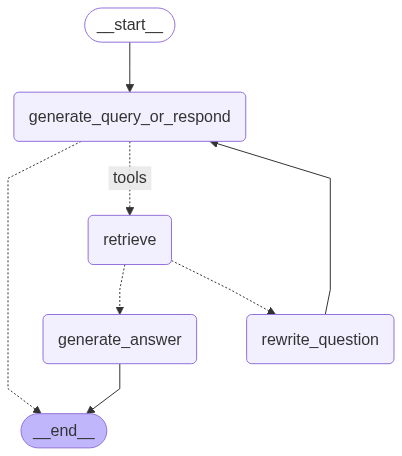

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming the run
We stream node updates to observe the agent's decisions step-by-step. This helps debug and explain the agentic behavior in real-time.

In [17]:
config = {"configurable": {"thread_id": "thread_1"}}

input_message = (
    "What is the main contribution of the 'A Survey of LLM-Driven AI Agent Communication' paper?"
)

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": input_message,
            }
        ]
    },
    stream_mode="values",
    config=config,
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the main contribution of the 'A Survey of LLM-Driven AI Agent Communication' paper?
================================== Ai Message ==================================

<think>
Okay, let me try to figure out how to approach this. The user is asking about the main contribution of a specific paper titled "A Survey of LLM-Driven AI Agent Communication". 

First, I need to check if there's a paper with that exact title in the arXiv database. The user mentioned it's a survey paper, so it's likely a recent one. But in the previous interactions, the assistant used the arxiv_paper_retriever function to get information about AI agent communication papers. The tool response from earlier shows references to papers like [318] by Yingxuan Yang et al. (arXiv:2504.16736) titled "A survey of ai agent protocols" and [204] by Erik Miehling et al. (arXiv:2503.00237) titled "Agentic ai needs a systems theory".

Wait, th

In [18]:
input_message = "Who's the main author?"

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": input_message,
            }
        ]
    },
    stream_mode="values",
    config=config,
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Who's the main author?
================================== Ai Message ==================================

<think>
Okay, the user is asking "Who's the main author?" after a previous interaction where I provided the main contribution of a specific paper. Let me check the context.

In the last tool response, the paper title was "A Survey of LLM-Driven AI Agent Communication: Protocols, Security Risks, and Defense Countermeasures" with authors listed as Dezhang Kong, Shi Lin, Zhenhua Xu, Zhebo Wang, Minghao Li, Yufeng Li, Yilun Zhang, Hujin Peng, Zeyang Sha, Yuyuan Li, Changting Lin, Xun Wang, Xuan Liu, Ningyu Zhang, Chaochao Chen, Muhammad Khurram Khan, Meng Han.

The user wants to know the main author. In academic papers, especially surveys, the main author is often the first author. The list shows Dezhang Kong as the first author. However, sometimes the main author might be determined by the contribution, b

## Inspecting the chat history

We can check the stored conversation

In [19]:
chat_history = graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

What is the main contribution of the AI agent communication paper?
================================== Ai Message ==================================

<think>
Okay, the user is asking about the main contribution of the AI agent communication paper. Hmm, first I need to figure out which specific paper they're referring to. The term "AI agent communication" is pretty broad. There are several papers on this topic, like maybe the one from the AI Safety Institute or something else.

Wait, the tool provided is arxiv_paper_retriever, which takes a query. So I should use that to look up the most relevant paper. The user probably means a recent paper, maybe the one that's popular or has significant contributions. Let me think, there's a paper titled "AI Agent Communication" on arXiv, but I'm not sure. Alternatively, maybe it's a specific paper from a conference.

Since the user didn't specify the title, I need to cr

# Basic offline evaluation with NDCG@k

We check if the chunks' ranking is sufficient

In [20]:
from math import log2
from typing import List

from sklearn.metrics import ndcg_score


def dcg(relevances: List[int]) -> float:
    """
    Discounted Cumulative Gain for a ranked list of binary relevances.
    rel in {0,1}; rank starts from 1; DCG = sum_{i}(rel_i / log2(i+1)).
    """
    return sum((rel / log2(idx + 2)) for idx, rel in enumerate(relevances))


def ndcg_at_k(relevances: List[int], k: int) -> float:
    """
    Compute NDCG@k for a ranked list of binary relevances.
    - relevances: list of 0/1 labels in rank order (retriever output order)
    - k: cutoff
    """
    r = relevances[:k]
    ideal = sorted(r, reverse=True)
    return ndcg_score([r], [ideal])


def grade_binary(question: str, context: str) -> int:
    """
    Binary relevance using the existing grader LLM (yes->1, no->0).
    Reuses GRADE_PROMPT + GradeDocuments for consistency.
    """
    prompt = GRADE_PROMPT.format(question=question, context=context)
    resp = grader_model.with_structured_output(GradeDocuments).invoke(
        [{"role": "user", "content": prompt}]
    )
    return 1 if resp.binary_score == "yes" else 0


def evaluate_ndcg(queries: List[str], k: int = 5) -> dict:
    """
    Evaluate NDCG@k over a set of queries using the current retriever and LLM-based binary labels.
    Returns a dict with mean NDCG and per-query breakdown.
    """
    scores = []
    for q in queries:
        docs = retriever.get_relevant_documents(q)
        relevances = [grade_binary(q, d.page_content) for d in docs]
        scores.append(ndcg_at_k(relevances, k))
    return {
        "k": k,
        "num_queries": len(queries),
        "ndcg@k_mean": float(np.mean(scores)) if scores else 0.0,
        "per_query": scores,
    }


# Example local evaluation set (kept small for fast local run)
queries = [
    "What was the challange in the selection Principles of the Most Relevant Surveys?",
    "What stages of agent communication are discussed?",
    "How many types of relevant surveys are there?",
    "Which figure illustrates a typical architecture of LLM-driven agents?",
    "Do agents have worse security than LLMs?",
]
ndcg_report = evaluate_ndcg(queries, k=5)
print("NDCG@5 report:", ndcg_report)

/var/folders/gh/wtmb1km14f710f4f7s07wk380000gn/T/ipykernel_88652/657142174.py:44: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(q)


NDCG@5 report: {'k': 5, 'num_queries': 5, 'ndcg@k_mean': 0.35385596211497444, 'per_query': [0.0, 0.0, 0.0, 1.0, 0.7692798105748722]}
